In [26]:
# usual imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# torch and torchvision in order to build the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as Func


In [27]:
# define neural network architecture
# based on VGG style neural network

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        
        # N x N x 1 --> N x N x 64
        self.conv_1_64 = nn.Conv2d(1, 64, 3, padding=1)
        
        # N x N x 64 --> N x N x 64
        self.conv_64_64 = nn.Conv2d(64,64,3,padding = 1) 
        
        # N x N x 64 --> N x N x 128
        self.conv_64_128 = nn.Conv2d(64, 128, 3, padding = 1) 
        
        # N x N x 128 --> N x N x 128
        self.conv_128_128 = nn.Conv2d(128,128,3,padding = 1)
        
        # N in case of MNIST is 7, so we go from 7 x 7 x 128 to a 1024, with further layers of 512, 256, 128 and finally 10
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        
        # initiate dropout layer with a given probability
        self.dropout = nn.Dropout(p=0.5);
        
        # initiate batch normalizations
        self.batch_norm_64 = nn.BatchNorm2d(64)
        self.batch_norm_128_2d = nn.BatchNorm2d(128)
        self.batch_norm_128_1d = nn.BatchNorm1d(128)
        self.batch_norm_256 = nn.BatchNorm1d(256)
        self.batch_norm_512 = nn.BatchNorm1d(512)
        self.batch_norm_1024 = nn.BatchNorm1d(1024)

    def forward(self, x):
        # input --> CNN 1, final dimensions 28 x 28 x 64
        x = F.relu(self.conv_1_64(x))
        x = self.batch_norm_64(x)
        
        # CNN 1 --> CNN 2 --> CNN 3, final dimensions 28 x 28 x 64
        x = self.batch_norm_64(F.relu(self.conv_64_64(x)))
        x = self.batch_norm_64(F.relu(self.conv_64_64(x)))
        
        # max pool, final dimensions 14 x 14 x 64
        x = F.max_pool2d(x, (2, 2))
        
        # CNN 3 --> CNN 4 --> CNN 5 --> CNN 6, final dimensions 14 x 14 x 128
        x = self.batch_norm_128_2d(F.relu(self.conv_64_128(x)))
        x = self.batch_norm_128_2d(F.relu(self.conv_128_128(x)))
        x = self.batch_norm_128_2d(F.relu(self.conv_128_128(x)))
        
        # max pool, final dimensions 7 x 7 x 128
        x = F.max_pool2d(x, (2, 2))
        
        # convert to a vector
        x = x.view(-1, self.num_flat_features(x))
        
        # fully connected layers
        x = self.dropout(self.batch_norm_1024(F.relu(self.fc1(x))))
        x = self.dropout(self.batch_norm_512(F.relu(self.fc2(x))))
        x = self.dropout(self.batch_norm_256(F.relu(self.fc3(x))))
        x = self.dropout(self.batch_norm_128_1d(F.relu(self.fc4(x))))
        x = self.fc5(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


netCNN = Net()

# select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(netCNN.parameters(), lr=0.001)
netCNN.to(device)

Net(
  (conv_1_64): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_64_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_64_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_128_128): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
  (batch_norm_64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_128_2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_128_1d): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_25

In [28]:
num_networks = 10
batchsize = 500
num_epochs = 50

img_rows = 28
img_cols = 28
# for convolutional neural network
x_train = pd.read_csv('train.csv')
x_test = pd.read_csv('test.csv')
y_train = x_train['label'].values
x_train = x_train.drop(['label'],1).values
x_test = x_test.values

x_train = x_train.reshape(np.shape(x_train)[0],1,img_rows,img_cols)
x_test = x_test.reshape(np.shape(x_test)[0],1,img_rows,img_cols)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

train = torch.from_numpy(x_train)
test = torch.from_numpy(x_test)
train_label = torch.from_numpy(y_train)
train_label = train_label.long()

In [29]:
affine = transforms.RandomAffine(degrees=10, translate=(.20,.20), scale=(.9,1.1))
output_all = torch.empty(test.size(0),10,num_networks)
num_iterations_train = int(train.size(0)/batchsize)
num_iterations_test = int(test.size(0)/batchsize)

time_start = time.time()

for n_network in range(num_networks):
    train_temp = torch.empty(np.shape(x_train)[0],1,img_rows,img_cols)
    netCNN = Net()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(netCNN.parameters(), lr=0.001)
    netCNN.to(device)
    for epoch in range(num_epochs):
        # it seems that these have to be done one at a time
        for n_input, input_data in enumerate(train):
            train_pil = transforms.ToPILImage(mode=None)(train[n_input])
            train_temp[n_input,:,:,:] = Func.to_tensor(affine(train_pil))

        running_loss = 0.0
        for i in range(num_iterations_train):

            inputs = train_temp[i*batchsize:(i+1)*batchsize]
            labels = train_label[i*batchsize:(i+1)*batchsize]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = netCNN(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('Epoch %d loss: %.3f' % (epoch + 1, running_loss/batchsize*1000))
        running_loss = 0.0

    print('Finished Training')

    prediction_all = torch.empty(train.size(0),1)
    for i in range(num_iterations_train):
        test_input = train[i*batchsize:(i+1)*batchsize]
        output = netCNN(test_input.to(device))
        _, prediction = torch.max(output,1)
        prediction_all[i*batchsize:(i+1)*batchsize,0] = prediction.cpu()

    match = train_label.int().reshape(train.size(0),1) == prediction_all.int()
    fraction = int(match.sum())/int(prediction_all.shape[0])
    print(fraction)
    
    #prediction_all = torch.empty(test.size(0),1)
    for i in range(num_iterations_test):
        test_input = test[i*batchsize:(i+1)*batchsize]
        output = netCNN(test_input.to(device))
        output_all[i*batchsize:(i+1)*batchsize,:,n_network] = output.data
        del output
        del test_input
        torch.cuda.empty_cache()

a,_ = torch.max(output_all,2)
_,predicted_final = torch.max(a,1)

runtime = time.time() - time_start
print('Elapsed Time: %.3f seconds' % runtime)

Epoch 1 loss: 191.835
Epoch 2 loss: 32.205
Epoch 3 loss: 19.374
Epoch 4 loss: 14.703
Epoch 5 loss: 13.137
Epoch 6 loss: 11.845
Epoch 7 loss: 9.929
Epoch 8 loss: 9.612
Epoch 9 loss: 8.433
Epoch 10 loss: 8.010
Epoch 11 loss: 8.119
Epoch 12 loss: 7.656
Epoch 13 loss: 7.196
Epoch 14 loss: 7.045
Epoch 15 loss: 6.830
Epoch 16 loss: 6.358
Epoch 17 loss: 6.151
Epoch 18 loss: 5.631
Epoch 19 loss: 5.509
Epoch 20 loss: 5.189
Epoch 21 loss: 5.082
Epoch 22 loss: 5.334
Epoch 23 loss: 5.123
Epoch 24 loss: 4.781
Epoch 25 loss: 5.040
Epoch 26 loss: 4.177
Epoch 27 loss: 4.304
Epoch 28 loss: 4.705
Epoch 29 loss: 3.869
Epoch 30 loss: 4.372
Epoch 31 loss: 4.049
Epoch 32 loss: 4.177
Epoch 33 loss: 4.227
Epoch 34 loss: 3.939
Epoch 35 loss: 3.960
Epoch 36 loss: 4.003
Epoch 37 loss: 4.058
Epoch 38 loss: 3.682
Epoch 39 loss: 3.635
Epoch 40 loss: 3.449
Epoch 41 loss: 3.793
Epoch 42 loss: 3.344
Epoch 43 loss: 3.413
Epoch 44 loss: 3.424
Epoch 45 loss: 3.674
Epoch 46 loss: 3.346
Epoch 47 loss: 3.185
Epoch 48 loss: 

Epoch 30 loss: 4.642
Epoch 31 loss: 4.276
Epoch 32 loss: 4.120
Epoch 33 loss: 3.680
Epoch 34 loss: 3.600
Epoch 35 loss: 3.986
Epoch 36 loss: 3.842
Epoch 37 loss: 3.929
Epoch 38 loss: 3.650
Epoch 39 loss: 3.283
Epoch 40 loss: 3.679
Epoch 41 loss: 3.660
Epoch 42 loss: 3.640
Epoch 43 loss: 3.931
Epoch 44 loss: 3.679
Epoch 45 loss: 2.999
Epoch 46 loss: 3.373
Epoch 47 loss: 3.257
Epoch 48 loss: 3.341
Epoch 49 loss: 3.027
Epoch 50 loss: 3.072
Finished Training
0.9981190476190476
Epoch 1 loss: 195.026
Epoch 2 loss: 33.411
Epoch 3 loss: 19.576
Epoch 4 loss: 15.214
Epoch 5 loss: 13.167
Epoch 6 loss: 11.579
Epoch 7 loss: 10.466
Epoch 8 loss: 9.085
Epoch 9 loss: 8.529
Epoch 10 loss: 8.166
Epoch 11 loss: 7.662
Epoch 12 loss: 6.727
Epoch 13 loss: 6.455
Epoch 14 loss: 6.895
Epoch 15 loss: 6.416
Epoch 16 loss: 6.355
Epoch 17 loss: 5.856
Epoch 18 loss: 5.921
Epoch 19 loss: 5.707
Epoch 20 loss: 5.372
Epoch 21 loss: 4.827
Epoch 22 loss: 4.819
Epoch 23 loss: 4.766
Epoch 24 loss: 4.571
Epoch 25 loss: 4.76

In [30]:
output_file = 'submission.csv'
pred_final_numpy = predicted_final.numpy()
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(predicted_final)) :
        f.write("".join([str(i+1),',',str(pred_final_numpy[i]),'\n']))

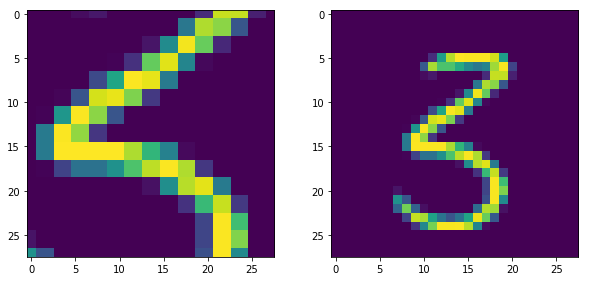

In [93]:
# test out the pytorch augmentations

index_ = 46;

#rotation = transforms.RandomRotation(degrees=30)
crop = transforms.CenterCrop(20)
affine = transforms.RandomAffine(degrees=0, scale=(2,2))

train_pil = transforms.ToPILImage(mode=None)(train[index_])
#train_pil = rotation(train_pil)
train_pil = affine(train_pil)
train_temp = Func.to_tensor(train_pil)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(train_temp[-1])
plt.subplot(2,2,2)
plt.imshow(train[index_][-1])